# 📦 Import Libraries

# 📰 Fake News Detection Dataset

This notebook uses the [Fake News Detection dataset](https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection) from Kaggle, which contains labeled news articles for building and evaluating fake news classifiers.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML & NLP Libraries

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

ML Models and Evaluation

In [88]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


# Load Dataset

In [89]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")
print(f"Fake.csv shape: {fake_df.shape[0]} rows, {fake_df.shape[1]} columns")
print(f"True.csv shape: {true_df.shape[0]} rows, {true_df.shape[1]} columns")

Fake.csv shape: 23481 rows, 4 columns
True.csv shape: 21417 rows, 4 columns


In [95]:
print('Fake News DataFrame:')
print(fake_df.head())
fake_df.info()

print('\nTrue News DataFrame:')
print(true_df.head())
true_df.info()


Fake News DataFrame:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column

Add labels

In [75]:
fake_df['label'] = 0  # Fake
true_df['label'] = 1  # True

# Data Pre-processing

Combine Dataset

In [76]:
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
print(f"Combined dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")

Combined dataset shape: 44898 rows, 5 columns


Handle Missing Values

In [77]:
# Drop nulls if any
df.dropna(inplace=True)

# Combine title + text (optional)
df['content'] = df['title'] + " " + df['text']
df['content'] = df['content'].str.lower().str.replace(r"[^a-zA-Z\s]", "", regex=True)

In [78]:
print("Missing values in each column:")
print(df.isnull().sum())
print("\nPercentage of missing values in each column:")
print((df.isnull().mean() * 100).round(2))

Missing values in each column:
title      0
text       0
subject    0
date       0
label      0
content    0
dtype: int64

Percentage of missing values in each column:
title      0.0
text       0.0
subject    0.0
date       0.0
label      0.0
content    0.0
dtype: float64


Fix Outliers

In [79]:
min_length = 10
initial_count = len(df)
df = df[df['content'].str.len() >= min_length]
print(f"Removed {initial_count - len(df)} rows with empty or very short content (less than {min_length} characters).")

max_length = df['content'].str.len().quantile(0.99)
df['content'] = df['content'].apply(lambda x: x[:int(max_length)])
print(f"Capped article length at {int(max_length)} characters (99th percentile).")

Removed 0 rows with empty or very short content (less than 10 characters).
Capped article length at 9044 characters (99th percentile).


# Features & Labels

In [80]:
X = df['content']
y = df['label']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

🔹 Feature Selection

In [81]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")

X_train_vec shape: (35918, 10000)
X_test_vec shape: (8980, 10000)


In [82]:
selector = SelectKBest(chi2, k=5000)
X_train_sel = selector.fit_transform(X_train_vec, y_train)
X_test_sel = selector.transform(X_test_vec)

🔹 Normalization

In [83]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

Model Setup

In [84]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

results = {}

## Model Training & Evaluation

Check Model-Fit with Accuracy

In [85]:
# Loop through models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Accuracy metrics
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n📌 {name}")
    print("Training Accuracy:", round(train_acc, 4))
    print("Testing Accuracy :", round(test_acc, 4))
    print("Precision         :", round(pre, 4))
    print("Recall            :", round(rec, 4))
    print("F1 Score          :", round(f1, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Save results
    results[name] = [acc, pre, rec, f1]

    # Overfit/Underfit Check
    print("🔍 Fit Check:", end=" ")
    if train_acc > 0.95 and (train_acc - test_acc) > 0.10:
        print("⚠️ Overfitting detected.")
    elif train_acc < 0.75 and test_acc < 0.75:
        print("⚠️ Underfitting detected.")
    else:
        print("✅ Model is well-fitted.")


KeyboardInterrupt: 

 🔹 Ensemble: Voting Classifier

In [ ]:
voting_model = VotingClassifier(
    estimators=[
        ('rf', models["Random Forest"]),
        ('lr', models["Logistic Regression"]),
        ('dt', models["Decision Tree"])
    ],
    voting='hard'
)
voting_model.fit(X_train_scaled, y_train)
y_vote = voting_model.predict(X_test_scaled)

model_names = []
for name, model in voting_model.estimators:
    if isinstance(model, RandomForestClassifier):
        model_names.append("Random Forest")
    elif isinstance(model, LogisticRegression):
        model_names.append("Logistic Regression")
    elif isinstance(model, KNeighborsClassifier):
        model_names.append("KNN")
    elif isinstance(model, DecisionTreeClassifier):
        model_names.append("Decision Tree")
    else:
        model_names.append(name)

# Evaluate all models to find the best one
best_model = None
best_f1 = -1
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_model = name

print(f"\n📌 Ensemble Voting Classifier (Models: {', '.join(model_names)})")
print("Accuracy:", accuracy_score(y_test, y_vote))
print("F1 Score:", f1_score(y_test, y_vote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_vote))
print(f"\n🏆 Best Individual Model: {best_model} (F1 Score: {best_f1:.4f})")

Visualization:

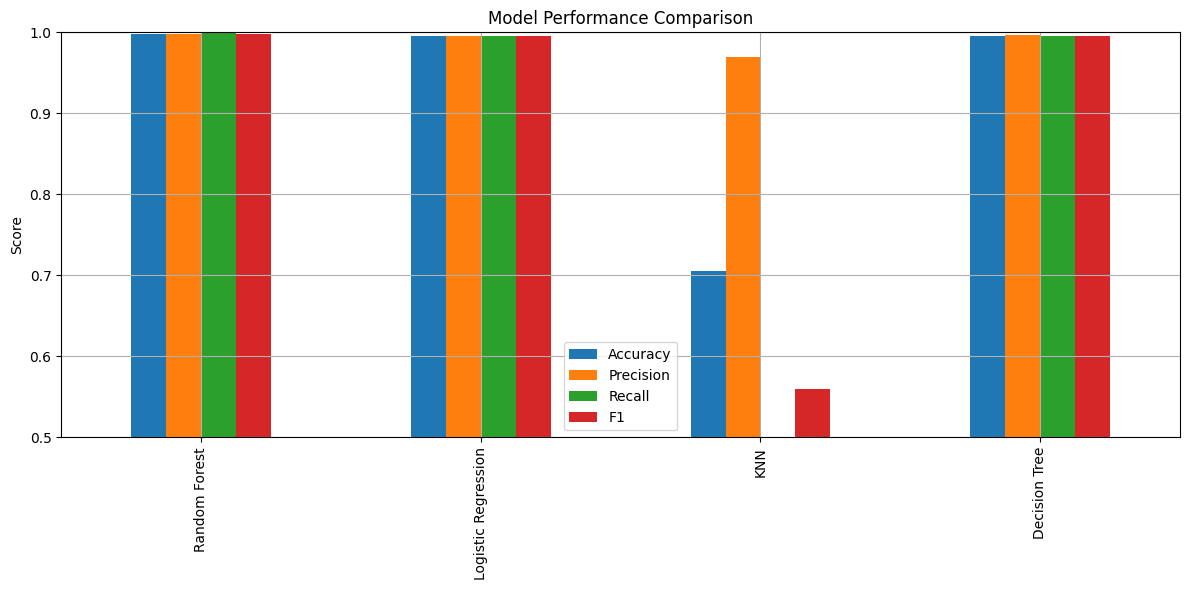

In [ ]:
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1"]).T
results_df.plot(kind='bar', figsize=(12, 6), title="Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plot confusion matrix for each model
from sklearn.metrics import confusion_matrix
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrix for ensemble voting classifier
if 'voting_model' in locals() or 'voting_model' in globals():
    y_vote = voting_model.predict(X_test_scaled)
    cm_vote = confusion_matrix(y_test, y_vote)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_vote, annot=True, fmt='d', cmap='Purples')
    plt.title("Confusion Matrix: Voting Classifier")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()